# Connection to GEE to show 20 year urbanisation of Christchurch

In [3]:
import geemap
import ee
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [4]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AfJohXnofqqa6Xl35YcHPTPMIAPvCEgTIkRXdW_oyTXnTNbkciGEQfV6Ymk



Successfully saved authorization token.


In [5]:
aoi = geemap.shp_to_ee('Christchurch-ward/christchurch-ward-map.shp')
geom = gpd.read_file('Christchurch-ward/christchurch-ward-map.shp')

In [6]:
# Choosing start and end date
start_date = '2023-01-01'
end_date = '2023-09-26'

# identifying christchurch city centre as the bounding geometry

collection = ee.ImageCollection("COPERNICUS/S2_SR")\
    .filterDate(start_date, end_date)\
    .filterBounds(aoi)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
    .sort('CLOUDY_PIXEL_PERCENTAGE')
   

Locate the image with a low cloudy pixel percentage from this year so we can use it to compute ndvi, homogenity, correlation, and other variables for the feature space

In [7]:
collection

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


**Image ID:** COPERNICUS/S2_SR/20230530T221611_20230530T221606_T59GPM

CLOUDY_PIXEL_OVER_LAND_PERCENTAGE:0.029768

CLOUDY_PIXEL_PERCENTAGE:0.588979

In [8]:
# Calculating and adding NDVI band
def compute_ndvi(img):
    # Calculate NDVI by normalizing the difference between near-infrared (B5) and red (B4) bands
    ndvi = img.normalizedDifference(['B5', 'B8']).rename('NDVI')
    
    # Add the computed NDVI band to the input image
    return img.addBands(ndvi)

collection = collection.map(compute_ndvi)

In [9]:
Map = geemap.Map(center=[172.725385802955, -43.5876073185094])

vis = {'bands': 'NDVI'}

Map.add_ee_layer(collection, vis)

In [10]:
Map

Map(center=[172.725385802955, -43.5876073185094], controls=(WidgetControl(options=['position', 'transparent_bg…

In [11]:
ndvi = collection.select('NDVI')

In [12]:
ndvi

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


In [13]:
# NDVI visualisation arguments
visArgs = {
  min: 0,
  max: 9000,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ]
}

In [14]:
Map.addLayer(ndvi, visArgs, 'NDVI image')

In [15]:
Map

Map(center=[172.725385802955, -43.5876073185094], controls=(WidgetControl(options=['position', 'transparent_bg…

In [16]:
# URL for ndvi over the year
videoArgs = {
  'dimensions': 768,
  'framesPerSecond': 5,
  'region': geom,
  'crs': 'EPSG:4326',
  min: -40.0,
  max: 35.0,
  'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

print(ndvi.getVideoThumbURL(videoArgs))

EEException: Invalid GeoJSON geometry.

## Visualising Low cloud percentage image

In [49]:
image = ee.Image('COPERNICUS/S2_SR/20230428T222549_20230428T222546_T59GPM')

# show properties
image

In [50]:
# compute ndvi
image = compute_ndvi(image)

In [19]:
# Map of NDVI on 
Map = geemap.Map(center = [-43.5876073185094, 172.725385802955], zoom=10)

vis = {'bands': 'NDVI',
       min:-1,
       max:1,
       'palette':['green','yellow']}

Map.add_ee_layer(image, vis)



### Get bounds from OSM Network

OSM will be a good place to retrieve our bounding box from. this way, all of the data we collect can be within the same two boudaries from melbourne and Christchurch.

In [20]:
import osmnx as ox

In [21]:
christchurch = 'Christchurch, New Zealand'

chc = ox.geocode_to_gdf(christchurch)

In [22]:
chc_bounds = chc.bounds

In [26]:
chc_bounds

,minx,miny,maxx,maxy
0,172.393025,-43.629201,172.821627,-43.389087


In [28]:
bbox = ee.Geometry.BBox(172.393025, -43.629201, 172.821627, -43.389087)

In [51]:
s2_clipped = image.clip(bbox)

In [41]:
Map = geemap.Map(center = [-43.5876073185094, 172.725385802955], zoom=10)

vis = {'bands': 'NDVI',
       min:-1,
       max:1,
       'palette':['green','yellow']}

Map.add_ee_layer(s2_clipped, vis)
Map

Map(center=[-43.5876073185094, 172.725385802955], controls=(WidgetControl(options=['position', 'transparent_bg…

### Selecting the relevant bands

In [44]:
s2_clipped

In [101]:
# relevant bands in new image
image = s2_clipped.select(['B8', 'B3', 'B2','B4','NDVI'])


In [100]:
Map.add_ee_layer(image, vis)
Map

Map(bottom=665768.0, center=[-43.54755275393054, 172.6484298706055], controls=(WidgetControl(options=['positio…

### Creating a dataframe from the Image

In [103]:
# checking projection info
projection = image.select('B3').projection().getInfo()

projection

{'type': 'Projection',
 'crs': 'EPSG:32759',
 'transform': [10, 0, 600000, 0, -10, 5200000]}

In [106]:
# setting crs and other information
crs = projection['crs']
crs_transform = projection['transform']
description = 'export_S2_chc'
scale=10
folder='FinalProject'

In [112]:
ee.batch.Export.image.toDrive(
    image=image,
    description=description,
    folder=folder,
    scale=scale,
    crs=crs
).start()

# Start the export task
#task.start()

In [120]:
# NDVI ONLY:
ndvi = image.select('NDVI')

In [125]:
# RGB ONLY:
RGB = image.select(['B4','B3','B2'])

In [127]:
# Alternate method:
#geemap.ee_export_image(ndvi, 'ndvi_christchurch.tif', crs=crs, crs_transform=crs_transform)

# RGB export:
geemap.ee_export_image(RGB, 'RGB_christchurch.tif', crs=crs, crs_transform=crs_transform)

Generating URL ...
An error occurred while downloading.
Total request size (86570955 bytes) must be less than or equal to 50331648 bytes.


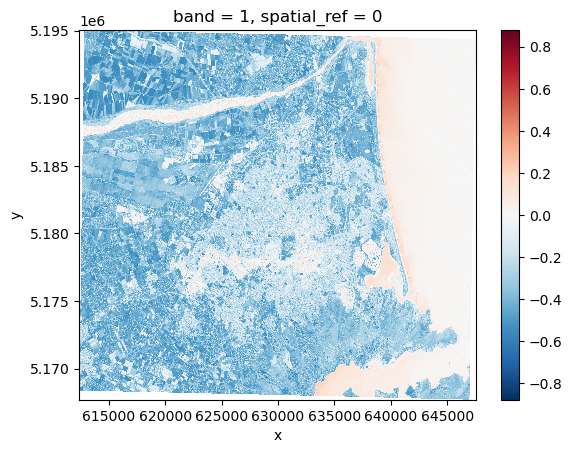

In [124]:
import rioxarray as rxr

# x array of the image
ndvi = rxr.open_rasterio('ndvi_christchurch.tif', masked=True)
ndvi.plot()

In [115]:
ndvi.shape

(6, 1368, 1759)

imread_('ndvi_christchurch.tif'): can't read header: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:155: error: (-2:Unspecified error) in function 'int cv::TiffDecoder::normalizeChannelsNumber(int) const'
> Unsupported number of channels:
>     'channels >= 1 && channels <= 4'
> where
>     'channels' is 6

